In [3]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader

In [4]:
!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Using GPU!


In [5]:
writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


#cpu = torch.ones(1).device

me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)

In [6]:
u,v=lapOp.diagonalize()

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_utils/tensor.py:16: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1337.)
  R = torch.cholesky(VTV, upper=True)  # (*BMV, nguess, nguess)
/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_impls/linalg/symeig.py:174: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion

# Spectrum with no training 

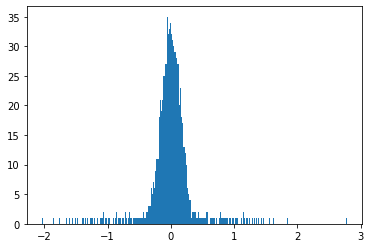

In [7]:
u = u.to('cpu')
plt.hist(u.numpy(),bins=300)
plt.show()

# Training the model 

In [8]:

optimizer = torch.optim.SGD
pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5)

Epoch 1
-------------------------------
Epoch training loss: 0.948414 	Epoch training accuracy: 72.46%                                      00 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 87.92%,                 Avg loss: 0.412242 



(0.4122418927550316, 87.91666666666667)

# Spectrum after training 

In [9]:
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)
uTrained,vTrained = lapOp.diagonalize()

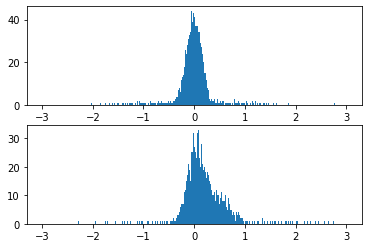

In [10]:
uTrained = uTrained.to('cpu')
plt.figure(1)
plt.subplot(211)
plt.hist(u.numpy(),bins=300,range=(-3,3))
plt.subplot(212)
plt.hist(uTrained.numpy(),bins=300,range=(-3,3))
plt.show()

# Spectrum evolution

Epoch 1
-------------------------------
Epoch training loss: 0.959637 	Epoch training accuracy: 73.52%                                                               
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.12%,                 Avg loss: 0.415117 

Epoch 1
-------------------------------
Epoch training loss: 0.346571 	Epoch training accuracy: 89.80%                                      500 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.03%,                 Avg loss: 0.303268 

Epoch 1
-------------------------------
Epoch training loss: 0.284174 	Epoch training accuracy: 91.74%                                      500 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 92.72%,                 Avg loss: 0.252811 



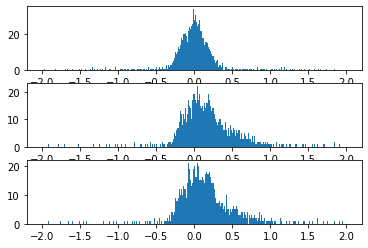

In [11]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=True))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 2


plt.figure(1)
epochs=epochs+1
for i in range(epochs):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    weights = [weight for weight in weights if len(weight.shape)==2]
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights)
    u,v = lapOp.diagonalize()
    plt.subplot(100*epochs + 11+i)
    plt.hist(u.to('cpu').numpy(),bins=300,range=(-2,2))
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(-0.0065, device='cuda:0')


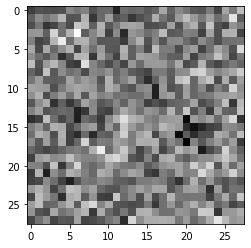

In [12]:
#Plotting eigenvectors 
idx = 6

img =-v.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')


print(u[285])

# With absolute value : 

Epoch 1
-------------------------------
Epoch training loss: 0.942728 	Epoch training accuracy: 72.58%                                                               
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.78%,                 Avg loss: 0.389433 

Epoch 1
-------------------------------
Epoch training loss: 0.344374 	Epoch training accuracy: 89.95%                                                                
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 90.78%,                 Avg loss: 0.314876 



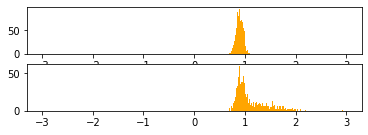

In [13]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='abs')
    uabs,vabs = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(uabs.to('cpu').numpy(),bins=300,range=(-3,3),color='orange')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(24.8764, device='cuda:0')


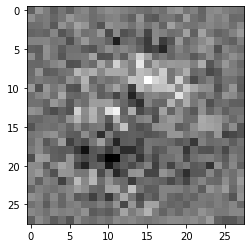

In [14]:
#Plotting eigenvectors 
idx = -8
print(uabs[idx])

img = vabs.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')



# With ReLU

Epoch 1
-------------------------------
Epoch training loss: 0.944205 	Epoch training accuracy: 72.73%                                      0 ]                      
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.83%,                 Avg loss: 0.397099 

Epoch 1
-------------------------------
Epoch training loss: 0.345840 	Epoch training accuracy: 89.97%                                      00 ]                      
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 90.82%,                 Avg loss: 0.315098 



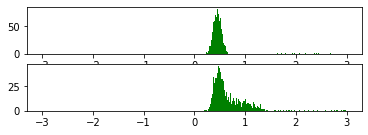

In [15]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    weights = [weight for weight in weights if len(weight.shape)==2]
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='relu')
    urelu,vrelu = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(urelu.to('cpu').numpy(),bins=300,range=(-3,3),color='green')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(1.8046, device='cuda:0')
torch.Size([894, 893])
tensor([-0.0069,  0.0309,  0.0107,  0.0484,  0.0134,  0.0302, -0.0346,  0.0216,
         0.0598,  0.0296], device='cuda:0')


tensor(8, device='cuda:0')

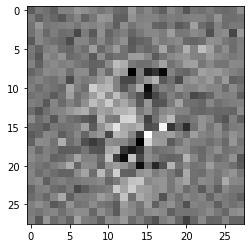

In [16]:
#Plotting eigenvectors 
idx = 789
print(urelu[idx])

img = vrelu.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

print(vrelu.shape)
print(-vrelu.T[idx][-10:])
(-vrelu.T[idx][-10:]).argmax()

In [17]:
torch.argmax(torch.abs(vrelu.T[-5][:10]))

tensor(9, device='cuda:0')

# High spectrum tests

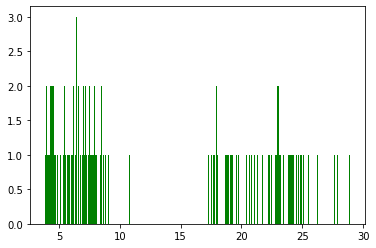

In [18]:
plt.hist(uabs.to('cpu')[28*28:].numpy(),bins=300,color='green')
plt.show()

In [19]:
import time 
#Plotting eigenvectors 
idx = 888
print(uabs[idx])


def saveEigenImages():
    i=28*28
    while i <893:
        idx = i 
        if vabs.T[idx][:28*28].mean()<(vabs.T[idx][:28*28].max()+vabs.T[idx][:28*28].min())/2:
            vabs.T[idx]=-vabs.T[idx]
        img = vabs.T[idx][:28*28].to('cpu')
        pixels = img.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.savefig('lapInputLayer' + "/eigenVec%02d.png" % idx)
        plt.show()

        i +=1 


tensor(25.4911, device='cuda:0')


In [20]:
!ls

basic_tutorial_gridsearch_benchmarking.ipynb  Ensemble_learning.ipynb
basic_tutorial_image.ipynb		      Intersection_Homology.ipynb
basic_tutorial_QandA.ipynb		      lapInputLayer
basic_tutorial_regression.ipynb		      lapInputLayerBin
basic_tutorial_tabular.ipynb		      lapInputLayer.zip
basic_tutorial_textClass.ipynb		      LaplacianSpectralAnalysis.ipynb
basic_tutorial_translation.ipynb	      optimising_topology.ipynb
compactification.ipynb			      orbit_5k_train.ipynb
data					      runs
decision_boundary_tori.ipynb		      TopactivationFC_tutorial.ipynb


# Binary mode

In [21]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from gdeep.data import DataLoaderFromArray
from torch.utils.data import DataLoader, random_split


writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")

dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


dataset = datasets.MNIST(root='./data',transform=ToTensor())
idx  = torch.logical_or(dataset.targets==4,dataset.targets==6)
dataset.targets = ((dataset.targets[idx]-4)/2).int()
dataset.data = dataset.data[idx]


my_dl = DataLoader(dataset)


train_len = int(len(dataset)*5/6)
train_set, test_set = random_split(dataset, [train_len, int(len(dataset)) - train_len])

dl_tr2 = DataLoader(train_set, batch_size=32, shuffle=True) # Train dataloader
dl_ts2 = DataLoader(test_set, batch_size=32, shuffle=False) # Test set 


""" Crappy stuff 
j = int(len(data)*5/6) 
print(data.type())


dl2 = DataLoaderFromArray(data[:j].unsqueeze(1),targets[:j],X_val=data[j:].unsqueeze(1),y_val=targets[j:])
dl_tr2, dl_ts2,_ = dl2.build_dataloaders(batch_size=32)



#dl_tr2.dataset = [(x[0],int(x[1].item())) for x in dl_tr2.dataset]
    
#dl_ts2.dataset = [(x[0],int(x[1].item())) for x in dl_ts2.dataset]

print(len(dl_tr),len(dl_ts))
print(len(dl_tr2),len(dl_ts2))
"""

' Crappy stuff \nj = int(len(data)*5/6) \nprint(data.type())\n\n\ndl2 = DataLoaderFromArray(data[:j].unsqueeze(1),targets[:j],X_val=data[j:].unsqueeze(1),y_val=targets[j:])\ndl_tr2, dl_ts2,_ = dl2.build_dataloaders(batch_size=32)\n\n\n\n#dl_tr2.dataset = [(x[0],int(x[1].item())) for x in dl_tr2.dataset]\n    \n#dl_ts2.dataset = [(x[0],int(x[1].item())) for x in dl_ts2.dataset]\n\nprint(len(dl_tr),len(dl_ts))\nprint(len(dl_tr2),len(dl_ts2))\n'

In [22]:
for x in dl_ts2.dataset:
    print(x[0].type())
    break 

torch.FloatTensor


Epoch 1
-------------------------------
Epoch training loss: 0.647299 	Epoch training accuracy: 70.83%                                       ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 95.41%,                 Avg loss: 0.451697 

Epoch 1
-------------------------------
Epoch training loss: 0.134647 	Epoch training accuracy: 98.00%                                      ]                       
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.42%,                 Avg loss: 0.051109 

Epoch 1
-------------------------------
Epoch training loss: 0.039032 	Epoch training accuracy: 98.79%                                      45 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.98%,                 Avg loss: 0.039781 

Epoch 1
-------------------------------
Epoch training loss: 0.035224 	Epoch t

Validation results: 
 Accuracy: 99.74%,                 Avg loss: 0.008814 

Epoch 1
-------------------------------
Epoch training loss: 0.011484 	Epoch training accuracy: 99.68%                                      5 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.85%,                 Avg loss: 0.009419 

Epoch 1
-------------------------------
Epoch training loss: 0.009723 	Epoch training accuracy: 99.74%                                      45 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.69%,                 Avg loss: 0.010526 

Epoch 1
-------------------------------
Epoch training loss: 0.010189 	Epoch training accuracy: 99.73%                                      45 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.69%,                 Avg loss: 0.006638 

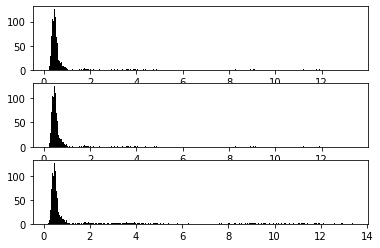

In [151]:


arch = [28*28, 50, 50, 50, 2]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr2, dl_ts2), loss_fn, writer)


epochs = 3
overfit = True


if overfit:
    for epoch in range(50):
         pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)

plt.figure(1)
for i in range(epochs):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='relu')
    ubin,vbin = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(ubin.to('cpu').numpy(),bins=300,color='black')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

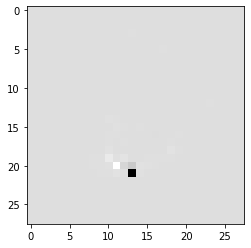

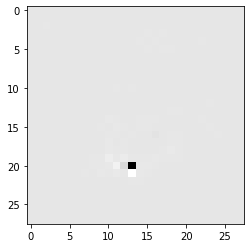

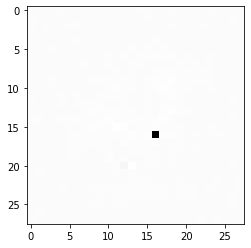

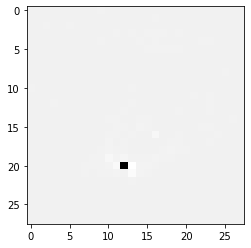

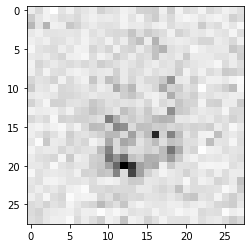

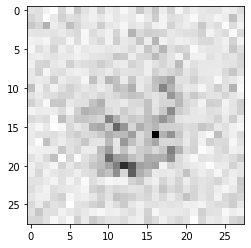

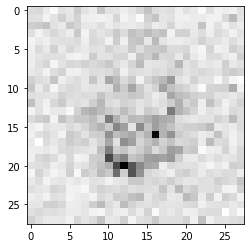

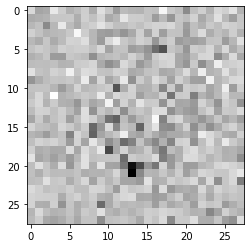

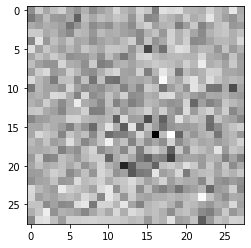

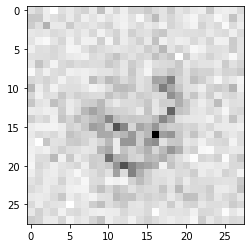

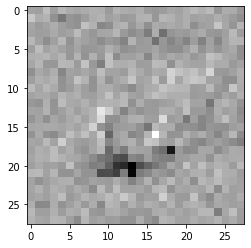

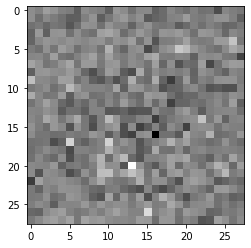

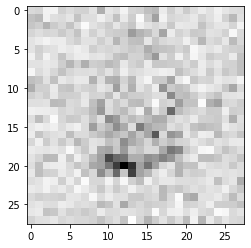

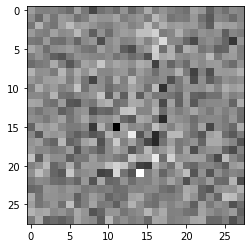

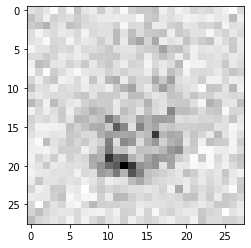

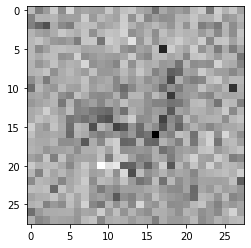

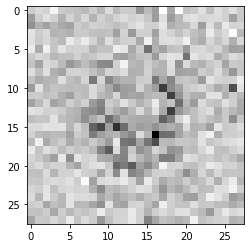

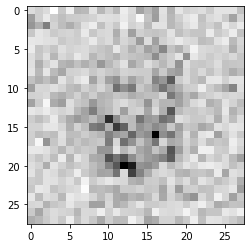

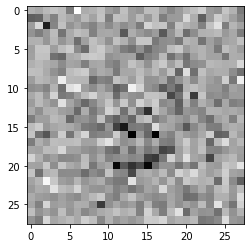

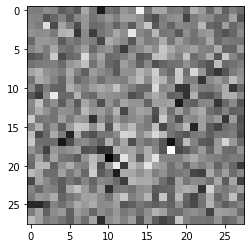

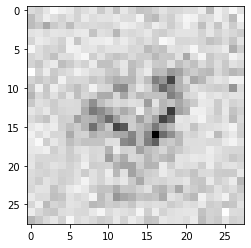

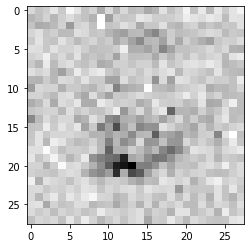

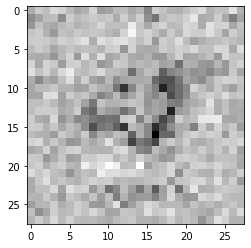

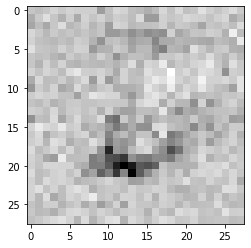

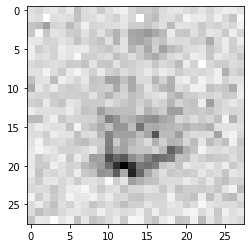

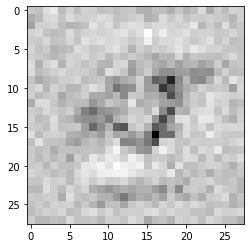

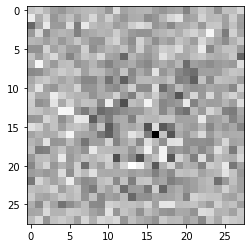

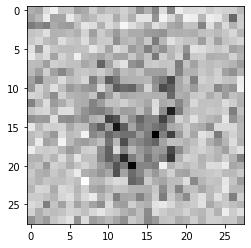

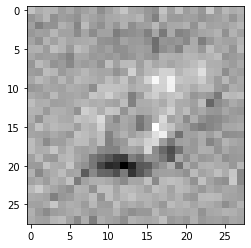

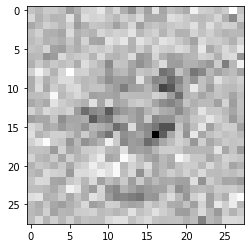

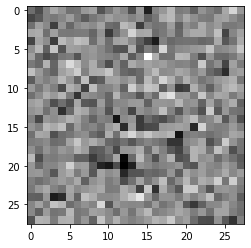

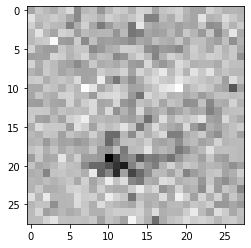

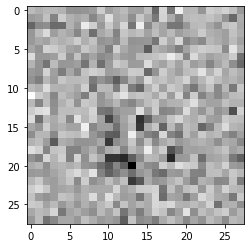

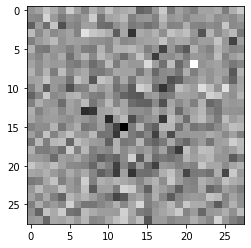

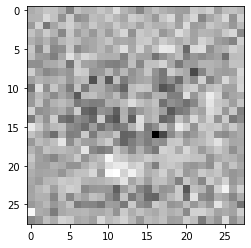

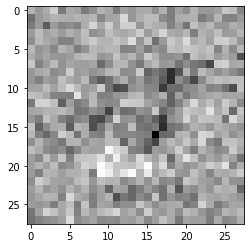

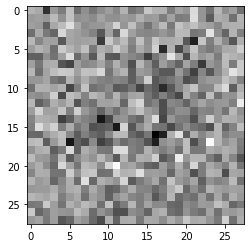

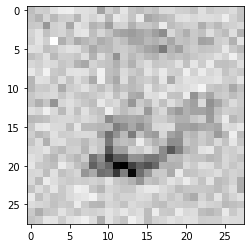

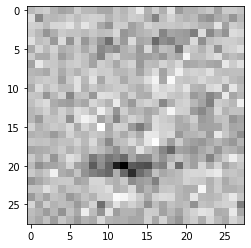

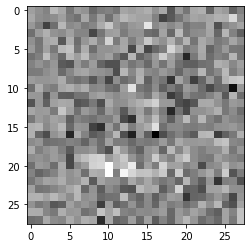

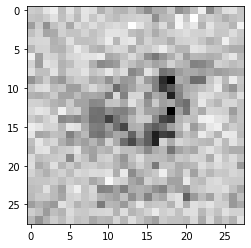

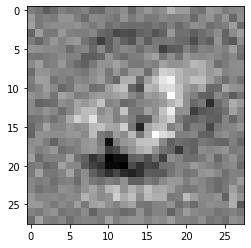

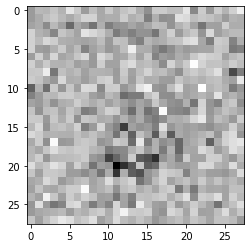

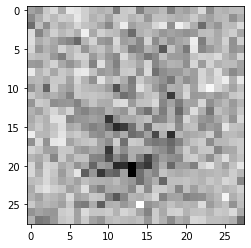

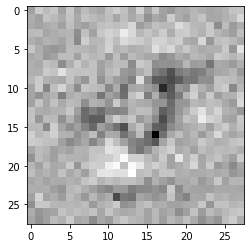

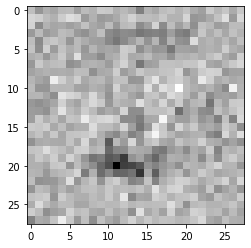

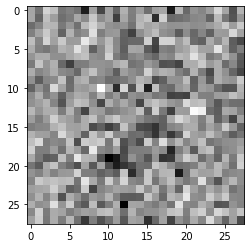

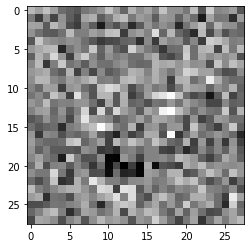

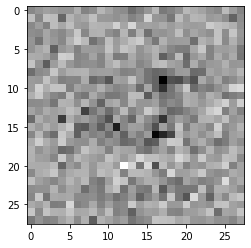

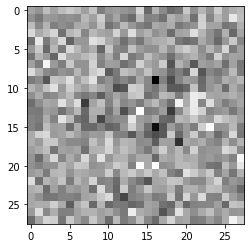

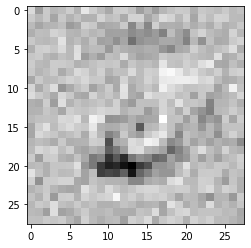

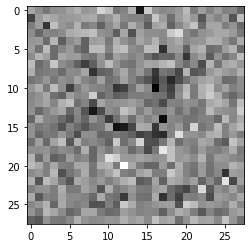

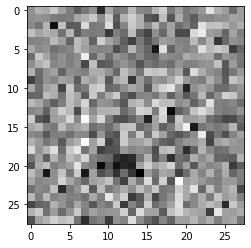

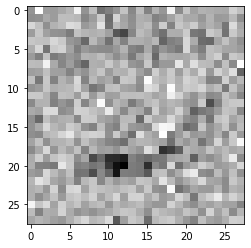

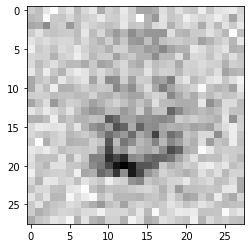

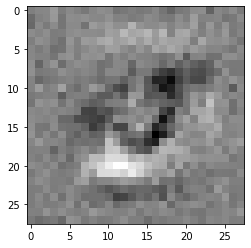

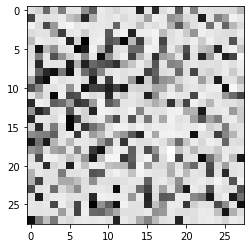

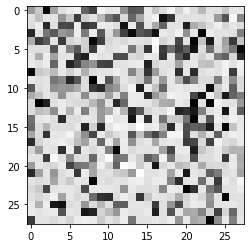

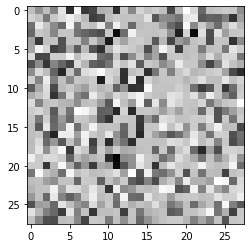

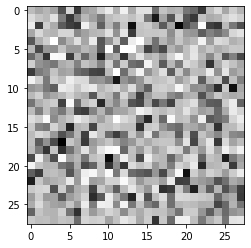

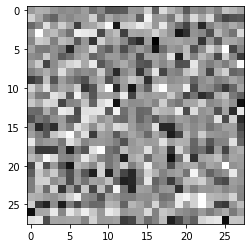

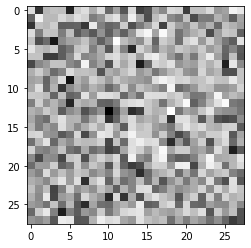

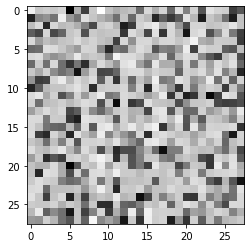

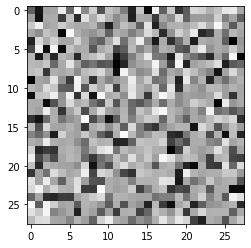

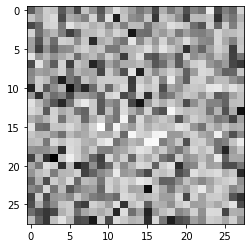

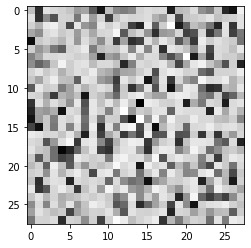

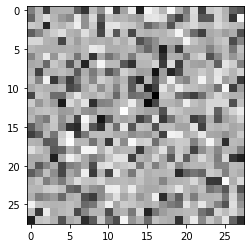

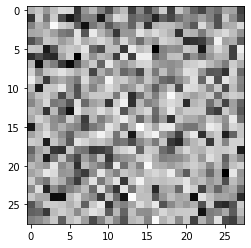

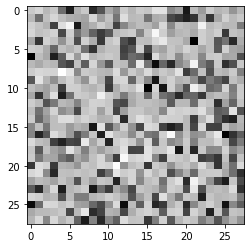

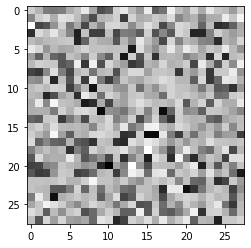

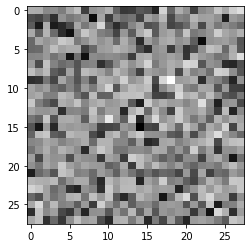

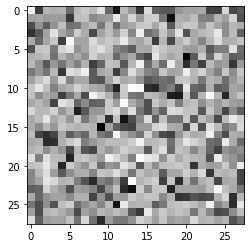

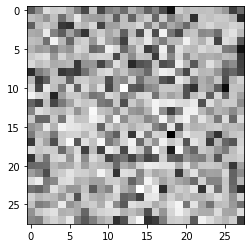

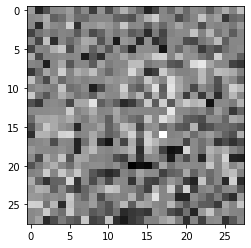

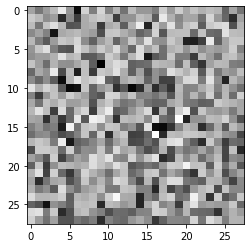

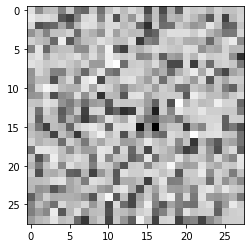

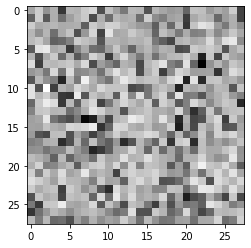

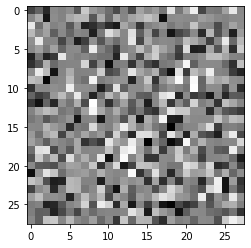

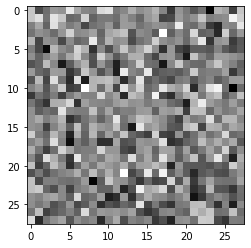

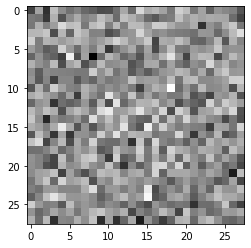

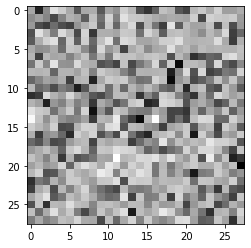

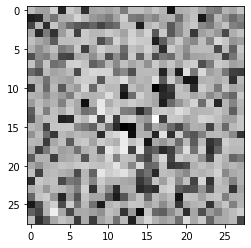

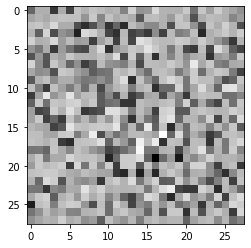

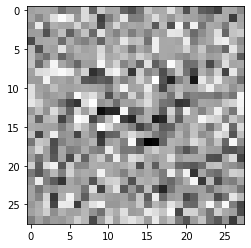

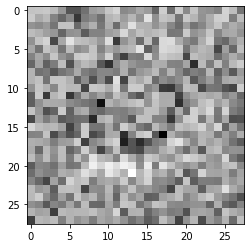

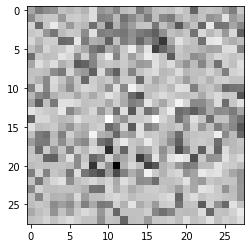

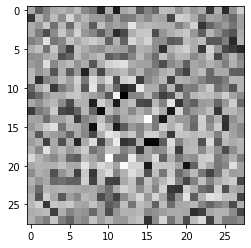

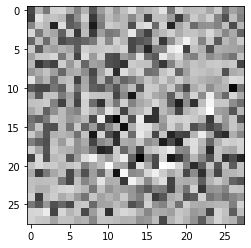

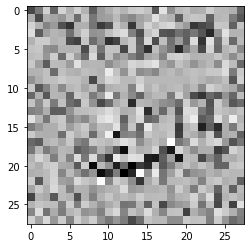

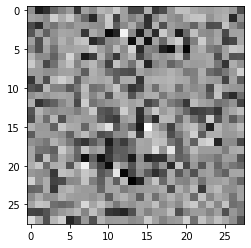

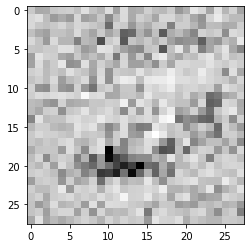

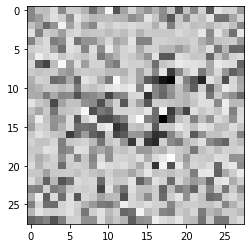

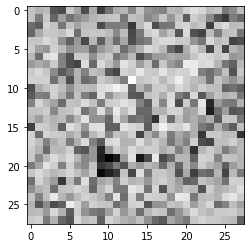

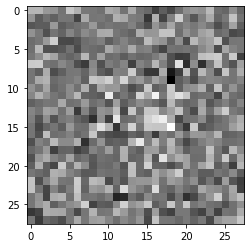

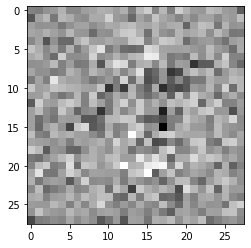

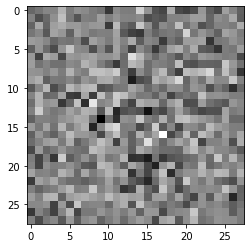

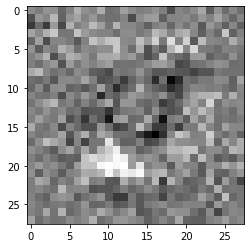

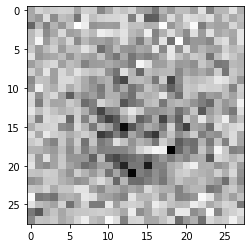

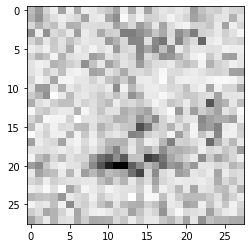

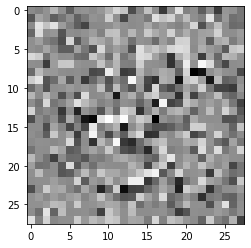

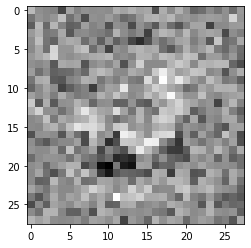

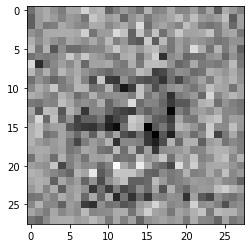

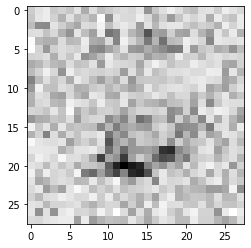

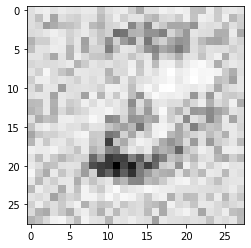

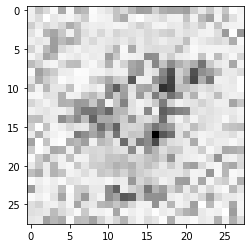

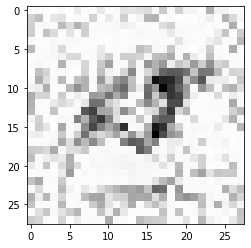

In [42]:
def saveEigenImages2():
    i=28*28-5
    while i <len(vbin.T):
        idx = i 
        if vbin.T[idx][:28*28].mean()<(vbin.T[idx][:28*28].max()+vbin.T[idx][:28*28].min())/2:
            vbin.T[idx]=-vbin.T[idx]
        img = vbin.T[idx][:28*28].to('cpu')
        pixels = img.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.savefig('lapInputLayerBin' + "/eigenVec%02d.png" % idx)
        plt.show()

        i +=1 

saveEigenImages2()

tensor(2.2597, device='cuda:0')
tensor([ 0.0018, -0.0066,  0.0052,  0.0016,  0.0330,  0.0090,  0.8629, -0.0937,
         0.0446, -0.0055], device='cuda:0')


tensor(6, device='cuda:0')

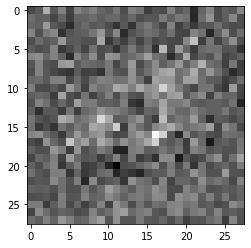

In [98]:
#Plotting eigenvectors 
idx = 815
print(ubin[idx])
img = vbin.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
print(-vbin.T[idx][-10:])
(-vbin.T[idx][-10:]).argmax()



In [52]:
vbin.T[28*28+25][872]


tensor(-0.5558, device='cuda:0')

# Getting to know the eigenvectors : metrics 

- sign 
- Total entropy 
- Argmax 
- value at argmax 
- spatial correlations on input 

In [133]:
def positivise(v):
    """Transforme le signe de chaque colonne de la matrice v de sorte à ce que l'argmax soit de signe positif """
    res = torch.zeros(v.shape)
    for idx in range(len(v.T)):
        res[:,idx]=torch.sign(v.T[idx][torch.abs(v.T[idx]).argmax()])*v.T[idx]
    return res 
        
def sign(vec):
    """Détermine la fraction de signes - pour un vecteur propre vec"""
    return (torch.relu(-torch.sign(vec)).sum())/len(vec)

def maxValue(vec):
    return vec.max()

def argMax(vec):
    return vec.argmax()

In [115]:
v = res.T[0]
print(torch.sign(v.T[torch.abs(v.T).argmax()]))

tensor(1.)


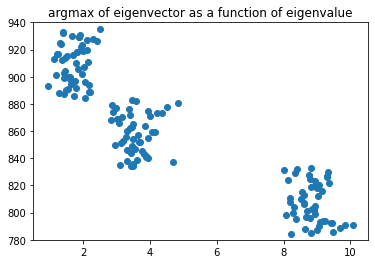

In [149]:
vbin = positivise(vbin)
vbin=vbin.to('cpu')
ubin = ubin.to('cpu')
plt.scatter(ubin[28*28:],[argMax(vec) for vec in vbin.T[28*28:]])
plt.title('argmax of eigenvector as a function of eigenvalue')
plt.ylim(780,940)
plt.show()

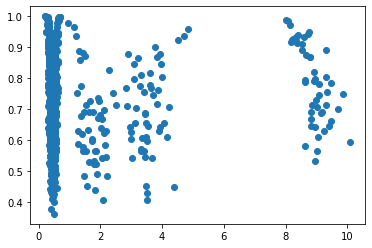

In [150]:
plt.scatter(ubin,[maxValue(vec) for vec in vbin.T])
plt.title('maximum value of eigenvector as a function of eigenvalue')